In [16]:
import os
import glob
import pandas as pd
import numpy as np
import tensorflow as tf

seed = 73

arr = []
path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"

for strat in os.listdir(path):
    for label in os.listdir(path+"/"+strat):
        for image in glob.glob(path+strat+"/"+label+"/"+"*.png"):
            arr.append({"path": image, "label": label, "strat": strat})
 
 
frame = pd.DataFrame(arr).sample(frac=1, random_state=seed)
print('> WithoutMask:', frame.value_counts("label")[0])
print('> WithMask:', frame.value_counts("label")[1])

frame

> WithoutMask: 5909
> WithMask: 5883


path        label  strat
11179  ../input/face-mask-12k-images-dataset/Face Mas...     WithMask  Train
1100   ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask   Test
4758   ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
10843  ../input/face-mask-12k-images-dataset/Face Mas...     WithMask  Train
3223   ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
...                                                  ...          ...    ...
4419   ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
8586   ../input/face-mask-12k-images-dataset/Face Mas...     WithMask  Train
4014   ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
8338   ../input/face-mask-12k-images-dataset/Face Mas...     WithMask  Train
5014   ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train

[11792 rows x 3 columns]

## **Data preprocessing**

In [17]:
import random

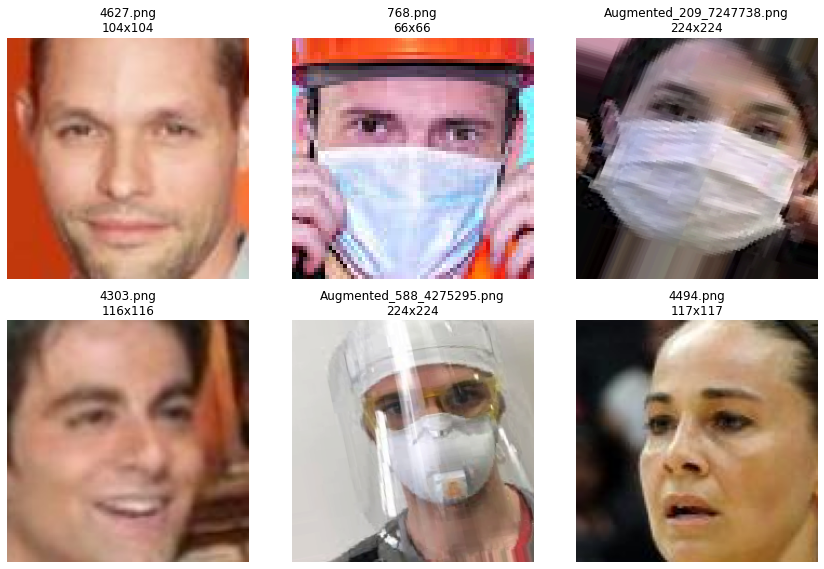

In [18]:
import matplotlib.pyplot as plt
import cv2


def plot_data(frame, num_images=6):
    # Lấy danh sách các đường dẫn hình ảnh từ DataFrame
    image_paths = frame['path'].tolist()
    
    # Chọn ngẫu nhiên num_images đường dẫn hình ảnh
    selected_paths = random.sample(image_paths, min(num_images, len(image_paths)))
    
    # Tạo một biểu đồ với 2 hàng và 3 cột
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    # Hiển thị các hình ảnh
    for ax, img_path in zip(axes, selected_paths):
        image = cv2.imread(img_path)
        if image is not None:
            # Chuyển đổi từ BGR sang RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Lấy kích thước ảnh
            height, width, _ = image.shape
            # Hiển thị ảnh
            ax.imshow(image_rgb)
            ax.set_title(f"{os.path.basename(img_path)}\n{width}x{height}")
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, 'Image not found', horizontalalignment='center', verticalalignment='center')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_data(frame)

In [19]:
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, 3)

In [20]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(rescale = 1./255,
                             horizontal_flip=True,
                             brightness_range=[1.1, 1.3],
                             rotation_range=30,
                             #vertical_flip=True,
                             zoom_range=0.15
                             )

In [21]:
def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          directory="../input", 
                          x_col="path",
                          y_col="label",
                          batch_size=64,
                          seed=seed,
                          shuffle=False,
                          class_mode="binary",
                          target_size=(IMG_SIZE,IMG_SIZE))
    return generator

In [22]:
train_df = frame[frame["strat"] == "Train"].sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

Found 10000 validated image filenames belonging to 2 classes.


In [23]:
valid_df = frame[frame["strat"] == "Validation"].sample(frac=1, random_state=seed)
valid_generator = get_generator(valid_df)

Found 800 validated image filenames belonging to 2 classes.


In [24]:
test_df = frame[frame["strat"] == "Test"].sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

Found 992 validated image filenames belonging to 2 classes.


In [25]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential

final_activation = 'sigmoid'
entropy = 'binary_crossentropy'

In [26]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    
    headModel = Dense(units=256)(headModel)
    headModel = BatchNormalization()(headModel)    
    headModel = Activation('relu')(headModel)
    headModel = Dropout(0.6, seed=73)(headModel)    
    
    headModel = Dense(1, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    
    return model

## **Xception Model**
**Reference**: https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/ch3-xception/implementation-of-xception-model

![](https://miro.medium.com/max/2961/1*hOcAEj9QzqgBXcwUzmEvSg.png)

In [27]:
def separable_conv_block(x, filters, block_num, conv_num, pre_activation=None):
    name = 'block{}_sepconv{}_'.format(block_num, conv_num)

    if pre_activation is True:
        x = Activation('relu', name=name+'act')(x)

    x = SeparableConv2D(filters, (3,3), padding='same', use_bias=False, 
                        name=name)(x)
    
    x = BatchNormalization(name=name+'bn')(x)

    if pre_activation is False:
        x = Activation('relu', name=name+'act')(x)
        
    return x

In [28]:
def middle_flow_block(x, filters, block_num):
    residual = x

    x = separable_conv_block(x, filters, block_num=block_num, 
                             conv_num='1', pre_activation=True)
    
    x = separable_conv_block(x, filters, block_num=block_num, 
                             conv_num='2', pre_activation=True)
    
    x = separable_conv_block(x, filters, block_num=block_num, 
                             conv_num='3', pre_activation=True)

    return add([x, residual])

In [29]:
def xception_block(x, filters, block_num, pre_activation=True):
    block = 'block{}_'.format(block_num)
    filter_conv1, filter_conv2 = filters

    residual = Conv2D(filter_conv2, (1, 1), strides=(2, 2), 
                      padding='same', use_bias=False)(x)
    
    residual = BatchNormalization()(residual)

    x = separable_conv_block(x, filter_conv1, block_num=block_num, 
                             conv_num='1', pre_activation=pre_activation)
    
    x = separable_conv_block(x, filter_conv2, block_num=block_num, 
                             conv_num='2', pre_activation=True)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name=block+'pool')(x)

    return add([x, residual])

In [30]:
def conv_block(x, filters, block_num, conv_num, strides=(1,1)):
    name = 'block{}_conv{}_'.format(block_num, conv_num)
    
    x = Conv2D(filters, (3,3), strides=strides, use_bias=False, name=name)(x)
    x = BatchNormalization(name=name+'bn')(x)
    x = Activation('relu', name=name+'act')(x)

    return x

def Xception_Model():
    
    img_input = Input(shape=input_shape)

    x = conv_block(img_input, 32, block_num='1', 
                   conv_num='1', strides=(2,2))
    
    x = conv_block(x, 64, block_num='1', conv_num='2')

    x = xception_block(x, (128, 128), '2', pre_activation=False)

    x = xception_block(x, (256, 256), '3')

    x = xception_block(x, (728, 728), '4')


    for i in range(8):
        block_num = str(5+i)
        x = middle_flow_block(x, 728, block_num)

    x = xception_block(x, (728, 1024), '13')

    x = separable_conv_block(x, 1536, block_num='14', 
                             conv_num='1', pre_activation=False) 
    
    x = separable_conv_block(x, 2048, block_num='14',
                             conv_num='2', pre_activation=False)
    
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    
    model = Model(inputs=img_input, outputs=x, name='xception')

    model = FCLayers(model)
    
    model.summary()
    return model


model = Xception_Model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_ (Conv2D)          (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1_[0][0]              
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

## **Model Training**

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import precision_score, recall_score, f1_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_generator):
        super().__init__()
        self.valid_generator = valid_generator
        self.train_precision = []
        self.val_precision = []
        self.train_f1 = []
        self.val_f1 = []

    def on_epoch_end(self, epoch, logs=None):
        val_predict = []
        val_targ = []

        # Lấy dữ liệu xác thực từ generator
        for i in range(len(self.valid_generator)):
            x, y = self.valid_generator[i]
            val_predict.extend(self.model.predict(x).round())
            val_targ.extend(y)

        val_predict = np.array(val_predict)
        val_targ = np.array(val_targ)

        recall = recall_score(val_targ, val_predict)
        precision = precision_score(val_targ, val_predict)
        f1 = f1_score(val_targ, val_predict)

        self.val_precision.append(precision)
        self.val_f1.append(f1)

        logs['val_recall'] = recall
        logs['val_precision'] = precision
        logs['val_f1'] = f1

        # Tính toán các chỉ số cho dữ liệu huấn luyện
        if 'accuracy' in logs:
            # Chỉ số Precision và F1-score cho dữ liệu huấn luyện có thể không có sẵn trong logs.
            # Bạn có thể tính toán chúng từ `logs['accuracy']` nếu cần thiết.
            # Ví dụ, thêm mã ở đây nếu có sẵn chỉ số cho dữ liệu huấn luyện.
            pass

metrics_callback = MetricsCallback(valid_generator)

early_stopping = EarlyStopping(patience=3, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose=1)

model_checkpoints = ModelCheckpoint("XceptionModel.h5", 
                                    save_best_only=True, verbose=1)

callbacks = [model_checkpoints, early_stopping, metrics_callback]

In [32]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])


history = model.fit(train_generator,validation_data  = valid_generator, epochs = 50, 
                              steps_per_epoch=(len(train_generator.labels) / 80) ,
                              validation_steps=(len(valid_generator.labels) / 80), 
                              callbacks = callbacks)

Epoch 1/50
125/125 [==============================] - 191s 1s/step - loss: 0.2978 - accuracy: 0.8895 - val_loss: 0.7499 - val_accuracy: 0.4922

Epoch 00001: val_loss improved from inf to 0.74992, saving model to XceptionModel.h5
Epoch 2/50
125/125 [==============================] - 141s 1s/step - loss: 0.1194 - accuracy: 0.9562 - val_loss: 0.7693 - val_accuracy: 0.4922

Epoch 00002: val_loss did not improve from 0.74992
Epoch 3/50
125/125 [==============================] - 137s 1s/step - loss: 0.0816 - accuracy: 0.9690 - val_loss: 0.6449 - val_accuracy: 0.7781

Epoch 00003: val_loss improved from 0.74992 to 0.64487, saving model to XceptionModel.h5
Epoch 4/50
125/125 [==============================] - 135s 1s/step - loss: 0.0650 - accuracy: 0.9759 - val_loss: 0.4947 - val_accuracy: 0.7063

Epoch 00004: val_loss improved from 0.64487 to 0.49473, saving model to XceptionModel.h5
Epoch 5/50
125/125 [==============================] - 136s 1s/step - loss: 0.0465 - accuracy: 0.9859 - val_los

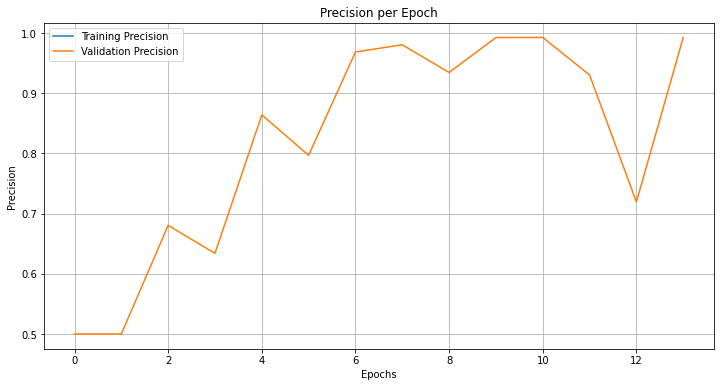

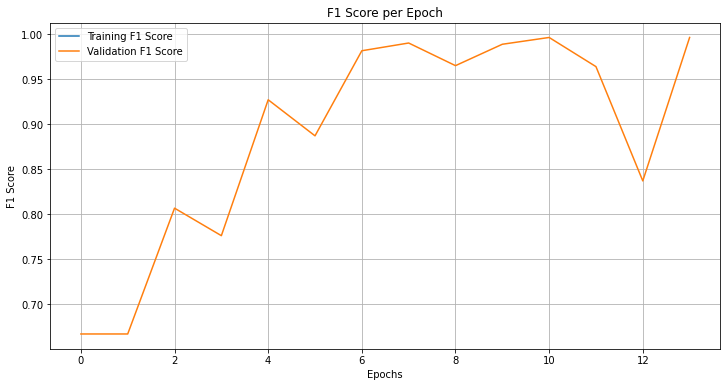

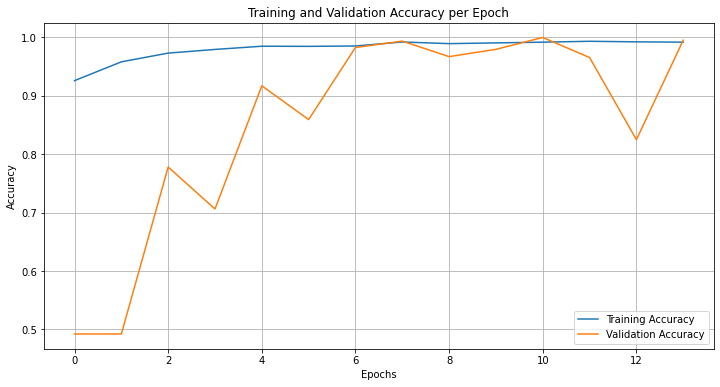

In [33]:
# Vẽ biểu đồ Độ chính xác (Precision)
plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.train_precision, label='Training Precision')
plt.plot(metrics_callback.val_precision, label='Validation Precision')
plt.title('Precision per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ Đánh giá cân bằng dữ liệu (F1-score)
plt.figure(figsize=(12, 6))
plt.plot(metrics_callback.train_f1, label='Training F1 Score')
plt.plot(metrics_callback.val_f1, label='Validation F1 Score')
plt.title('F1 Score per Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ Kết quả dự đoán (Accuracy)
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

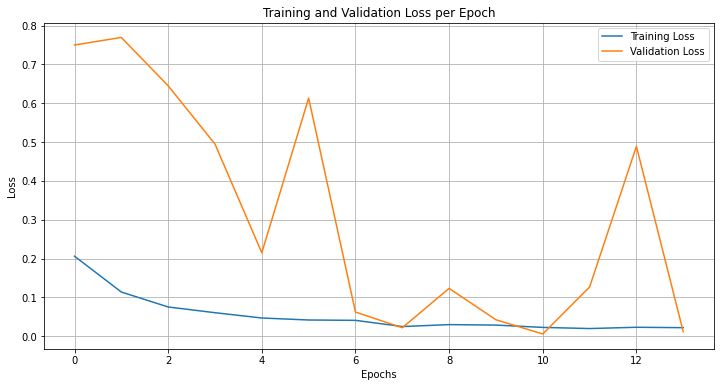

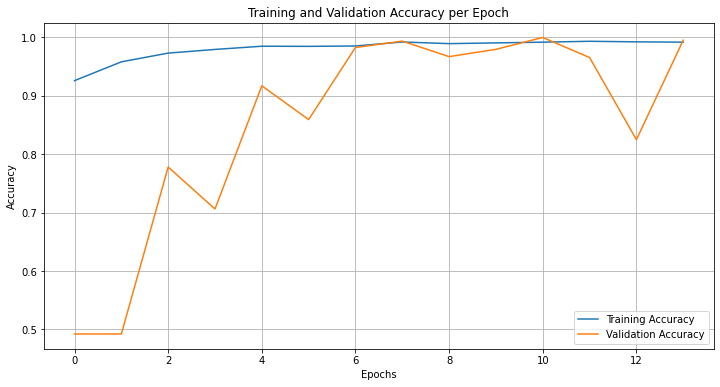

In [34]:
# Vẽ biểu đồ hàm mất mát
plt.figure(figsize=(12, 6))

# Hàm mất mát cho tập huấn luyện và tập kiểm tra
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Thêm tiêu đề và nhãn
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(12, 6))

# Độ chính xác cho tập huấn luyện và tập kiểm tra
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Thêm tiêu đề và nhãn
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

In [35]:
from tensorflow.keras.models import load_model
model = load_model("XceptionModel.h5")

## **Model Evaluation**

In [36]:
model.evaluate(test_generator, verbose=1)

16/16 [==============================] - 22s 1s/step - loss: 0.0200 - accuracy: 0.9940


[0.01996655948460102, 0.9939516186714172]

In [37]:
predictions = model.predict(test_generator, verbose = 1).round()

16/16 [==============================] - 15s 916ms/step


In [38]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
target_names = ['Has Mask','No Mask']

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_results():
    print(classification_report(test_generator.labels, predictions, target_names=target_names))
    plt.figure(figsize = (8,5))
    sns.heatmap(confusion_matrix(test_generator.labels, predictions), annot = True, 
                fmt="d",cmap = "Purples")
    plt.show()
    
    roc_acc = roc_auc_score(test_generator.labels, predictions)
    print('> ROC Accuracy: {}'.format(roc_acc.round(4)))

              precision    recall  f1-score   support

    Has Mask       1.00      1.00      1.00       483
     No Mask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



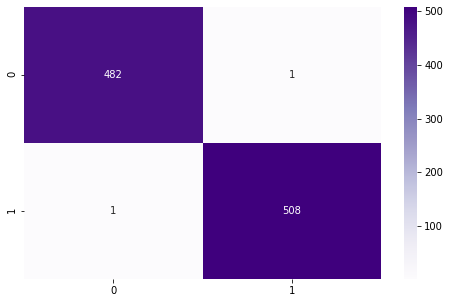

> ROC Accuracy: 0.998


In [40]:
print_results()

## **Face detection Model with Haar Cascade**

In [41]:
import cv2
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

def getFaces(img):
    gray_img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    faces = face_model.detectMultiScale(gray_img, scaleFactor=1.1, 
                                        minNeighbors=8)
    return faces

In [42]:
import PIL

def newSize(width, height):
    if width < 600:
        return newSize(width * 1.12 , height * 1.12)
    
    if width >= 1200:
        return newSize(width / 1.12 , height / 1.12)
        
    return int(width), int(height)
        
def AdjustSize(f):
    img = PIL.Image.open(f)
    width, height = img.size
    new_width, new_height = newSize(width, height)
    
    return (new_width, new_height)        

In [43]:

def Draw(img, face):
    (x,y,w,h) = face
    mask_label = {0:'Has Mask!',1:'No Mask'}
    label_color = {0: (0,255,0), 1: (255,0,0)}
    
    crop = img[y:y+h,x:x+w]
    
    crop = cv2.resize(crop,(IMG_SIZE, IMG_SIZE))
    crop = np.reshape(crop,[1,IMG_SIZE,IMG_SIZE,3]) / 255.0
    
    mask_result = model.predict(crop)
            
    pred_label = round(mask_result[0][0])
            
    cv2.putText(img,mask_label[pred_label],
                (x, y+90), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, label_color[pred_label], 2)
            
    cv2.rectangle(img,(x,y),(x+w,y+h), 
                label_color[pred_label],1)
    
    return img

In [44]:
from io import BytesIO
from skimage import io
from scipy.spatial import distance
import requests

MIN_DISTANCE = 0
    
def MaskDetection(imgUri):    
    response = requests.get(imgUri)
    f = BytesIO(response.content)
    
    img = io.imread(f)
    resize = AdjustSize(f)
    img = cv2.resize(img, resize)
    faces = getFaces(img)
    
    if len(faces)>=1:
        label = [0 for i in range(len(faces))]
        
        for i in range(len(faces)-1):
            for j in range(i+1, len(faces)):
                dist = distance.euclidean(faces[i][:2], 
                                          faces[j][:2])
                if dist < MIN_DISTANCE:
                    label[i] = 1
                    label[j] = 1
                
        for i in range(len(faces)):
            Draw(img, faces[i])
                        
        plt.figure(figsize=(16,14))
        plt.imshow(img)
            
    else:
        print("No Face!")

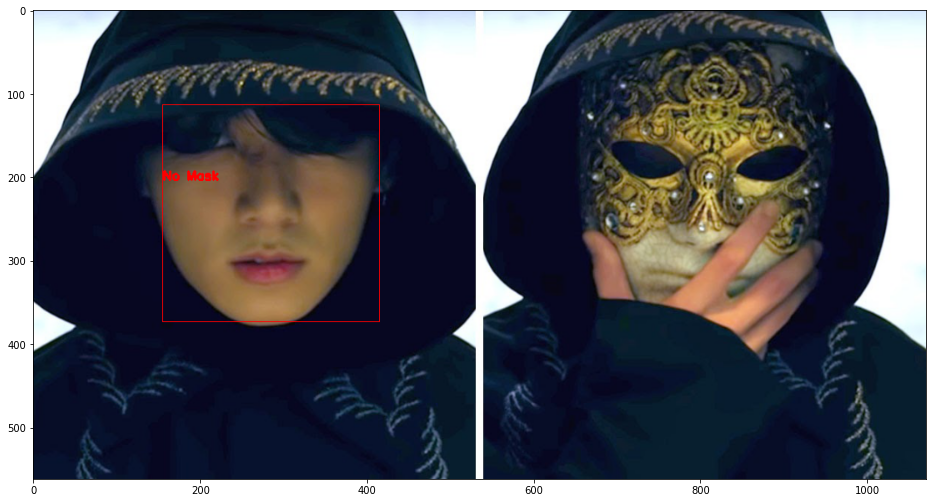

In [45]:
MaskDetection("https://lh3.googleusercontent.com/xx2yn_8a0rQMqcib1BcZRAnzt70OjX2o8RnaoSx3L-RpgBd229jAAmTfCeRgmDwarCfTsglYWTldswEmsHehJvX2YW8dnKVNXw=w1200-h630-rj-pp-e365")

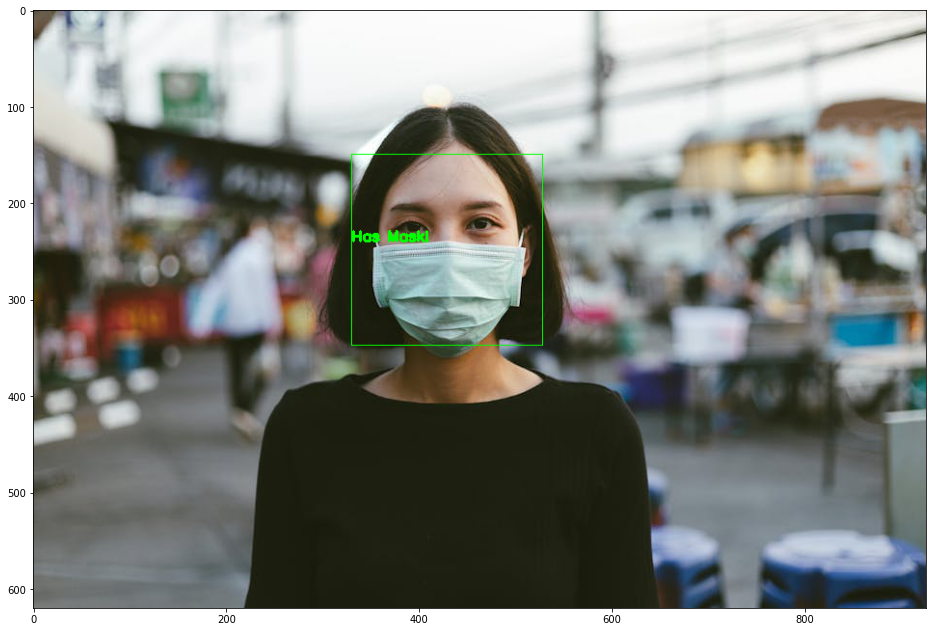

In [46]:
MaskDetection("https://images.theconversation.com/files/326038/original/file-20200407-18916-1p3qplf.jpg?ixlib=rb-1.1.0&rect=17%2C0%2C5734%2C3837&q=45&auto=format&w=926&fit=clip")

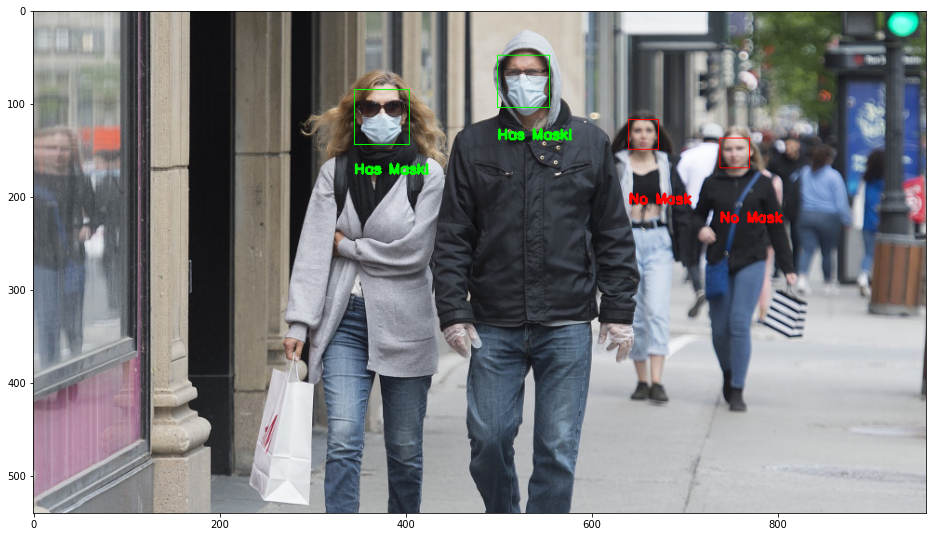

In [47]:
MaskDetection("https://www.ctvnews.ca/polopoly_fs/1.4986740.1592334933!/httpImage/image.jpg_gen/derivatives/landscape_960/image.jpg")

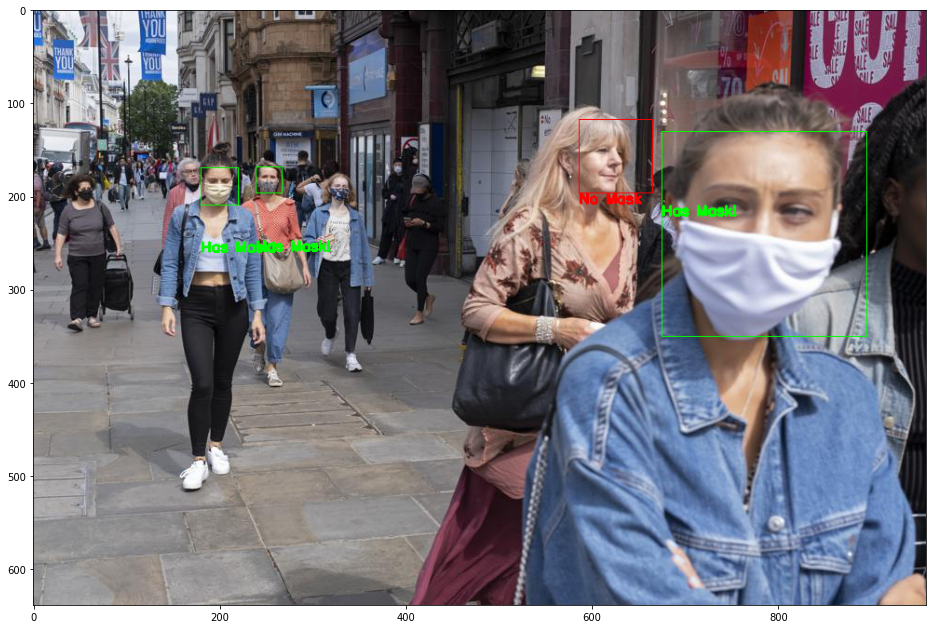

In [48]:
MaskDetection("https://specials-images.forbesimg.com/imageserve/1227664783/960x0.jpg?fit=scale")

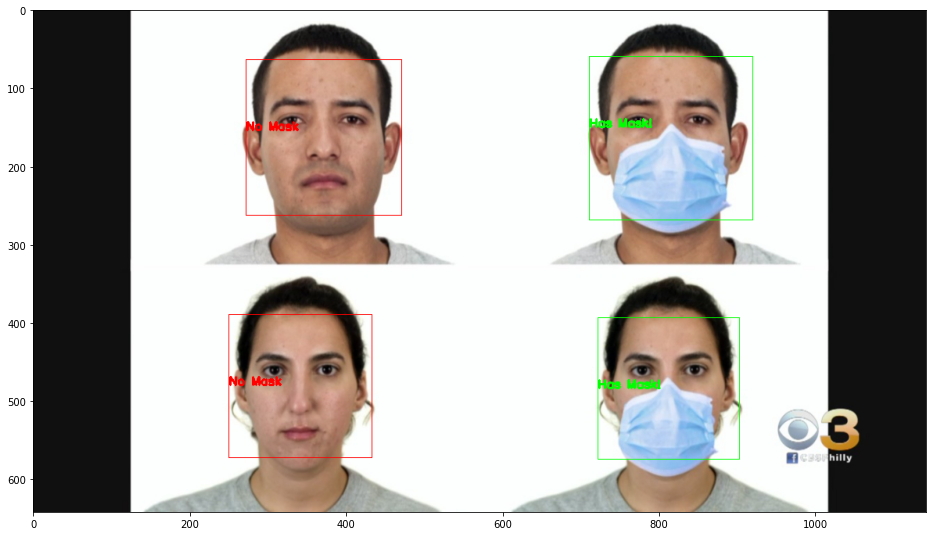

In [51]:
MaskDetection("https://assets1.cbsnewsstatic.com/i/cbslocal/wp-content/uploads/sites/15116066/2020/08/face-mask-study.jpg")

In [50]:
from tensorflow import keras

# In phiên bản của TensorFlow
print("TensorFlow version:", tf.__version__)

# In phiên bản của Keras
print("Keras version:", keras.__version__)

TensorFlow version: 2.4.1
Keras version: 2.4.0


In [ ]:
from IPython.display import FileLink
FileLink(r'./XceptionModel.h5')